In [2]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

## Chen et al

In [4]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
chen_patient_metadata[(chen_patient_metadata['Cancer Type'] != 'CRC')]

,Patient ID,Age,Gender,Cancer Type,Tumor Location,TNM,Tumor stage,dMMR/pMMR,MSI/MSS,POLE Mutation,TMB (Muts/Mb),Tumor Regression Ratio,Response,TRG status,Treatment Regimen
7,P11,65,Male,Duodenal carcinoma,Duodenum,T3N0M0,II,dMMR,MSI,No,1.78,1.0000,CR,TRG0,Pembrolizumab
19,P24,39,Male,Duodenal carcinoma,Duodenum,T4aN0M0,III,dMMR,MSI,No,24.45,0.2764,PR,TRG0,Sintilimab+ CapeOx


In [18]:
chen_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.CRC.woSD.run_meta.organized.tsv', sep='\t',)
chen_metadata.head(1)

,Accession,SampleID,PatientID,TreatmentStage,TreatmentPoint,BiopsySite,MMR,MSI,TMB,Response,LibraryType,TumorLocation,CancerType
0,HRR1372976,P04-N-I,P04,Pre,Baseline,Normal,dMMR,MSI,487,CR,scRNA-seq,Ascending colon,CRC


In [3]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [5]:
AlleleTable_NAT     = pd.read_csv("/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NAT.NanoMnT.AlleleTable.tsv.gz", sep='\t')
AlleleTable_Tumor   = pd.read_csv("/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/Tumor.NanoMnT.AlleleTable.tsv.gz", sep='\t')

/tmp/ipykernel_179216/532861758.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  AlleleTable_Nat     = pd.read_csv("/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NAT.NanoMnT.AlleleTable.tsv.gz", sep='\t')


In [89]:
dict_Identifier_to_isTumor = { tup.Identifier : bool(tup.Manual_CellType_lvl_1=='Tumor epithelial') for tup in adata.obs.itertuples() }
for identifier in AlleleTable_Tumor['Identifier']:
    try:
        dict_Identifier_to_isTumor[identifier]
    except KeyError:
        dict_Identifier_to_isTumor[identifier] = 'N/A'
for identifier in AlleleTable_NAT['Identifier']:
    try:
        dict_Identifier_to_isTumor[identifier]
    except KeyError:
        dict_Identifier_to_isTumor[identifier] = 'N/A'
        
AlleleTable_Tumor['isTumor'] = [ dict_Identifier_to_isTumor[identifier] for identifier in AlleleTable_Tumor['Identifier'] ]
AlleleTable_NAT['isTumor'] = [ dict_Identifier_to_isTumor[identifier] for identifier in AlleleTable_NAT['Identifier'] ]

print(AlleleTable_Tumor[(AlleleTable_Tumor['isTumor']!='N/A')].shape[0] / AlleleTable_Tumor.shape[0])
print(AlleleTable_NAT[(AlleleTable_NAT['isTumor']!='N/A')].shape[0] / AlleleTable_NAT.shape[0])

0.35688983819429915
0.0035322883818079127


In [90]:
AlleleTable_Tumor['BiopsySite'] = 'Tumor'
AlleleTable_NAT['BiopsySite'] = 'NAT'
AlleleTable = pd.concat([AlleleTable_NAT, AlleleTable_Tumor])
AlleleTable.reset_index(inplace=True, drop=True)

In [20]:
AlleleTable.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t', index=False, compression='gzip')

In [4]:
AlleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t', )

/tmp/ipykernel_46854/1483400063.py:1: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  AlleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t', )


In [5]:
AlleleTable.dropna(inplace=True)
AlleleTable = AlleleTable[AlleleTable['SampleID'].isin(adata.obs['SampleID'])].copy()

### Crude inspection of STR profile by STR length

In [19]:
dict_SampleID_to_PatientID = dict()
for tup in chen_metadata.itertuples():
    dict_SampleID_to_PatientID[tup.SampleID] = tup.PatientID
AlleleTable['PatientID'] = [ dict_SampleID_to_PatientID[SID] for SID in AlleleTable['SampleID'] ]

/tmp/ipykernel_46854/503450140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AlleleTable['PatientID'] = [ dict_SampleID_to_PatientID[SID] for SID in AlleleTable['SampleID'] ]


In [20]:
STRProfileByLength = list()
for PatientID, edf in AlleleTable.groupby("PatientID"):
    for isTumor, edf2 in edf.groupby("isTumor"):
        for reference_STR_allele, edf3 in edf2.groupby("reference_STR_allele"):
            STRProfileByLength.append( [PatientID, reference_STR_allele, isTumor, np.mean(edf3['diff'].dropna()), len(edf3.dropna()), ] )
STRProfileByLength = pd.DataFrame(STRProfileByLength, columns=['PatientID', 'reference_STR_allele', 'isTumor', 'AvgSTRDiff', 'NumSTRLoci'])

In [21]:
dict_PatientID_to_AvgSTRDiff = dict()
for PatientID, edf in STRProfileByLength[STRProfileByLength['isTumor']==True].groupby('PatientID'):
    dict_PatientID_to_AvgSTRDiff[PatientID] = np.mean(edf['AvgSTRDiff'])
dict_PatientID_to_AvgSTRDiff = dict(sorted(dict_PatientID_to_AvgSTRDiff.items(), key=lambda x:x[1], reverse=True))
dict_PatientID_to_AvgSTRDiff.keys()
# dict_keys(['P18', 'P17', 'P24', 'P11', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04'])
# dict_keys(['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04'])

dict_keys(['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04'])

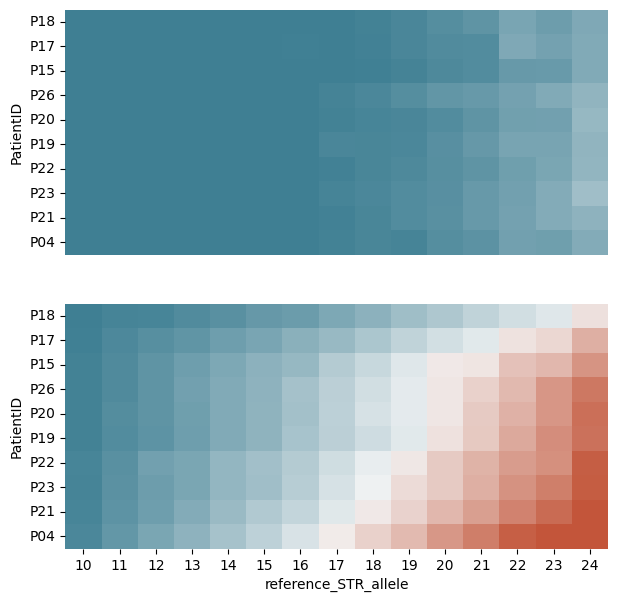

In [23]:
# Calculate tumor-normal by microsatellite length
fig, axes = plt.subplots(2, 1, figsize=(7, 7), dpi=100, sharex=True,)
# plt.figure(figsize=(7, 2), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

vmin_e, vmax_e = -8, 0

ax = sns.heatmap(STRProfileByLength[(STRProfileByLength['isTumor']==False)].pivot( index='PatientID', columns='reference_STR_allele', values='AvgSTRDiff' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, ax=axes[0],
            vmin=vmin_e, vmax=vmax_e,cbar=False
            )
ax.set_xlabel('');
ax.tick_params(bottom=False)
ax = sns.heatmap(STRProfileByLength[(STRProfileByLength['isTumor']==True) ].pivot( index='PatientID', columns='reference_STR_allele', values='AvgSTRDiff' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, ax=axes[1],
            vmin=vmin_e, vmax=vmax_e, cbar=False
            )

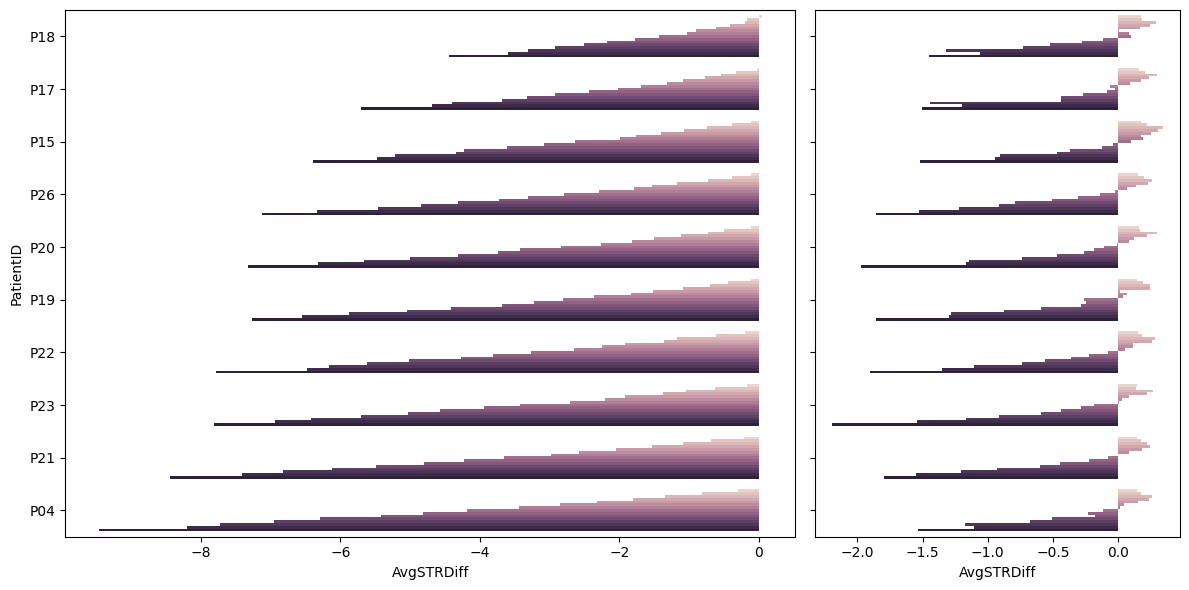

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]}, sharey=True, sharex=False)
ax = sns.barplot(data=STRProfileByLength[(STRProfileByLength['isTumor']==True) & 
                                    (STRProfileByLength['PatientID'].isin(list_heatmap_patient_order))], 
            x='AvgSTRDiff', y='PatientID', order=list_heatmap_patient_order, 
            hue='reference_STR_allele', legend=None, ax=axes[0]
            )
ax = sns.barplot(data=STRProfileByLength[(STRProfileByLength['isTumor']==False) & 
                                    (STRProfileByLength['PatientID'].isin(list_heatmap_patient_order))], 
            x='AvgSTRDiff', y='PatientID', order=list_heatmap_patient_order, 
            hue='reference_STR_allele', legend=None, ax=axes[1]
            )
fig.tight_layout()

## Joanito et al

In [ ]:
joanito_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/patient_clinical_information.csv', encoding = "ISO-8859-1")
joanito_metadata = joanito_metadata[joanito_metadata['dataset'].isin(['CRC-SG1', 'KUL5', 'KUL3'])].copy()
joanito_metadata = joanito_metadata[joanito_metadata['MSS_MSI']=='MSI-H'].copy()
joanito_metadata

In [ ]:
PATH_SG1_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/EGAD00001008555-metadata/organized_metadata.tsv"
PATH_KUL_metadata = "/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/KUL/organized_metadata.tsv"

SG1_metadata = pd.read_csv(PATH_SG1_metadata, sep='\t')
KUL_metadata = pd.read_csv(PATH_KUL_metadata, sep='\t')

In [708]:
KUL_metadata[KUL_metadata['patient.ID'].isin(['SC035', 'SC044'])]

,sample_alias,patient.ID,file_ID,Gender,MSS_MSI,Site,Sidedness,Group_Stage,Stage_TNM,iCMS_transcriptomic,iCMS_inferCNV,KRAS,BRAF,TP53,APC,PIK3CA,LymphNode,Normal,Tumor,CMS
0,SC035_tumor1,SC035,EXT048,M,MSI-H,Ascending colon,R,II,T3N0M0,iCMS3,iCMS3,wt,wt,wt,mut,NaN,1.0,1.0,2.0,CMS1
1,SC035_tumor2,SC035,EXT049,M,MSI-H,Ascending colon,R,II,T3N0M0,iCMS3,iCMS3,wt,wt,wt,mut,NaN,1.0,1.0,2.0,CMS1
2,SC035_normal,SC035,EXT050,M,MSI-H,Ascending colon,R,II,T3N0M0,iCMS3,iCMS3,wt,wt,wt,mut,NaN,1.0,1.0,2.0,CMS1
3,SC035_lymphnode,SC035,EXT051,M,MSI-H,Ascending colon,R,II,T3N0M0,iCMS3,iCMS3,wt,wt,wt,mut,NaN,1.0,1.0,2.0,CMS1
20,SC044_tumor1,SC044,EXT124,F,MSI-H,Caecum,R,III,T3N1M0,iCMS3,iCMS3,wt,wt,wt,wt,NaN,0.0,2.0,3.0,CMS1
21,SC044_tumor2,SC044,EXT125,F,MSI-H,Caecum,R,III,T3N1M0,iCMS3,iCMS3,wt,wt,wt,wt,NaN,0.0,2.0,3.0,CMS1
22,SC044_normal1,SC044,EXT126,F,MSI-H,Caecum,R,III,T3N1M0,iCMS3,iCMS3,wt,wt,wt,wt,NaN,0.0,2.0,3.0,CMS1
23,SC044_tumor3,SC044,EXT127,F,MSI-H,Caecum,R,III,T3N1M0,iCMS3,iCMS3,wt,wt,wt,wt,NaN,0.0,2.0,3.0,CMS1
24,SC044_tumor4,SC044,EXT128,F,MSI-H,Caecum,R,III,T3N1M0,iCMS3,iCMS3,wt,wt,wt,wt,NaN,0.0,2.0,3.0,CMS1
25,SC044_normal2,SC044,EXT129,F,MSI-H,Caecum,R,III,T3N1M0,iCMS3,iCMS3,wt,wt,wt,wt,NaN,0.0,2.0,3.0,CMS1


In [ ]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')

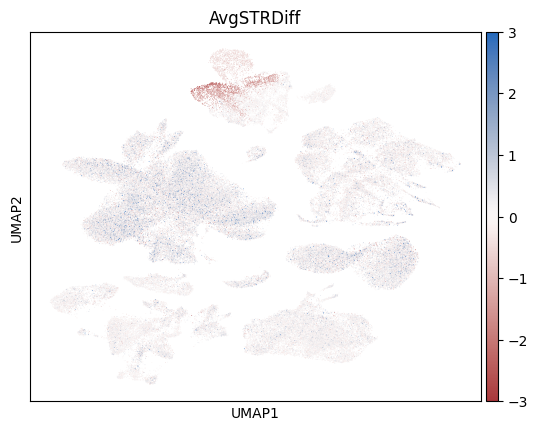

In [224]:
sc.pl.umap(adata, color=['AvgSTRDiff'], cmap='vlag_r', vmin=-3, vmax=3)

In [49]:
AlleleTable = pd.read_csv("/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/NanoMnT.AlleleTable.tsv.gz", sep='\t')

In [91]:
dict_Identifier_to_isTumor = { tup.Identifier : bool(tup.Manual_CellType_lvl_1=='Tumor epithelial') for tup in adata.obs.itertuples() }
for identifier in AlleleTable['Identifier']:
    try:
        dict_Identifier_to_isTumor[identifier]
    except KeyError:
        dict_Identifier_to_isTumor[identifier] = 'N/A'
AlleleTable['isTumor'] = [ dict_Identifier_to_isTumor[identifier] for identifier in AlleleTable['Identifier'] ]
AlleleTable[(AlleleTable['isTumor']!='N/A')].shape[0] / AlleleTable.shape[0]

0.4887344431349798

### Crude inspection of STR profile by STR length

In [72]:
dict_SampleID_to_PatientID = dict()
for tup in SG1_metadata.itertuples():
    dict_SampleID_to_PatientID[list(tup)[3]] = list(tup)[2]
for tup in KUL_metadata.itertuples():
    dict_SampleID_to_PatientID[list(tup)[3]] = list(tup)[2]
AlleleTable['PatientID'] = [ dict_SampleID_to_PatientID[SID] for SID in AlleleTable['SampleID'] ]

In [180]:
STRProfileByLength = list()
for PatientID, edf in AlleleTable.groupby("PatientID"):
    for isTumor, edf2 in edf.groupby("isTumor"):
        for reference_STR_allele, edf3 in edf2.groupby("reference_STR_allele"):
            STRProfileByLength.append( [PatientID, reference_STR_allele, isTumor, np.mean(edf3['diff'].dropna()), len(edf3.dropna()), ] )
STRProfileByLength = pd.DataFrame(STRProfileByLength, columns=['PatientID', 'reference_STR_allele', 'isTumor', 'AvgSTRDiff', 'NumSTRLoci'])

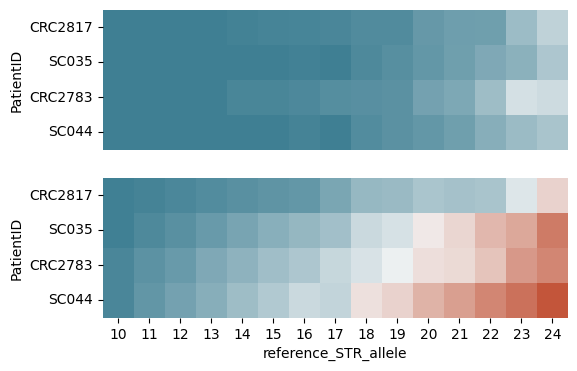

In [220]:
# Calculate tumor-normal by microsatellite length
fig, axes = plt.subplots(2, 1, figsize=(7, 3.5), dpi=100, sharex=True,)
# plt.figure(figsize=(7, 2), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['CRC2817', 'SC035','CRC2783', 'SC044']

vmin_e, vmax_e = -10, 0

ax = sns.heatmap(STRProfileByLength[(STRProfileByLength['isTumor']==False)].pivot( index='PatientID', columns='reference_STR_allele', values='AvgSTRDiff' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, ax=axes[0],
            vmin=vmin_e, vmax=vmax_e,cbar=False
            )
ax.set_xlabel('');
ax.tick_params(bottom=False)
ax = sns.heatmap(STRProfileByLength[(STRProfileByLength['isTumor']==True) ].pivot( index='PatientID', columns='reference_STR_allele', values='AvgSTRDiff' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, ax=axes[1],
            vmin=vmin_e, vmax=vmax_e, cbar=False
            )


<Axes: xlabel='AvgSTRDiff', ylabel='PatientID'>

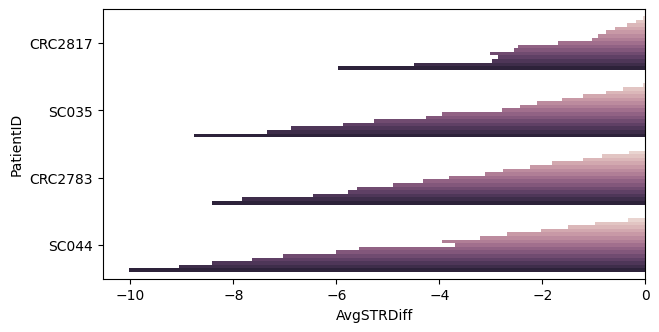

In [217]:
plt.figure(figsize=(7, 3.5), dpi=100, )
ax = sns.barplot(data=STRProfileByLength[(STRProfileByLength['isTumor']==True) & 
                                    (STRProfileByLength['PatientID'].isin(['CRC2817', 'SC035', 'CRC2783', 'SC044']))], 
            x='AvgSTRDiff', y='PatientID', order=['CRC2817', 'SC035', 'CRC2783', 'SC044'], 
            hue='reference_STR_allele', legend=None,
            )

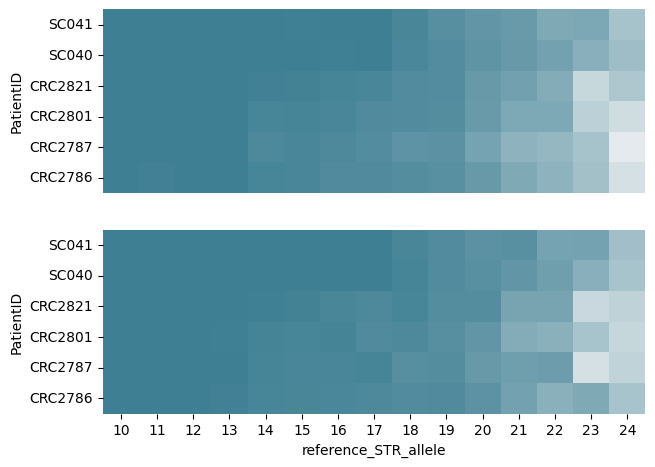

In [188]:
# Calculate tumor-normal by microsatellite length
fig, axes = plt.subplots(2, 1, figsize=(7, 5.25), dpi=100, sharex=True,)
# plt.figure(figsize=(7, 2), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['SC041', 'SC040', 'CRC2821', 'CRC2801', 'CRC2787', 'CRC2786', ]

vmin_e, vmax_e = -10, 0

ax = sns.heatmap(STRProfileByLength[(STRProfileByLength['isTumor']==False)].pivot( index='PatientID', columns='reference_STR_allele', values='AvgSTRDiff' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, ax=axes[0],
            vmin=vmin_e, vmax=vmax_e,cbar=False
            )
ax.set_xlabel('');
ax.tick_params(bottom=False)
ax = sns.heatmap(STRProfileByLength[(STRProfileByLength['isTumor']==True) ].pivot( index='PatientID', columns='reference_STR_allele', values='AvgSTRDiff' ).reindex(list_heatmap_patient_order), 
            cmap=palette_e, ax=axes[1],
            vmin=vmin_e, vmax=vmax_e, cbar=False
            )


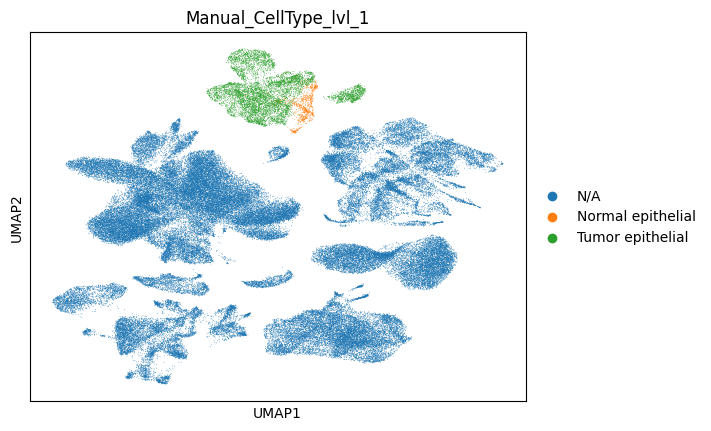

In [14]:
sc.pl.umap(adata[adata.obs['NumSTRLoci']!=0], color=['Manual_CellType_lvl_1'])

### Validation using loci with higher coverage

In [226]:
dict_locus_to_totalCoverage = dict()
for locus, edf in AlleleTable.groupby('locus'):
    dict_locus_to_totalCoverage[locus] = len(edf)

In [229]:
mininumCoverage = 30
set_highlyCoveredLoci = set(locus for locus, coverage in dict_locus_to_totalCoverage.items() if coverage>=mininumCoverage)
len(set_highlyCoveredLoci)

22700

In [231]:
STRLocusAndCoverage = list()
for PatientID, edf in AlleleTable[(AlleleTable['locus'].isin(set_highlyCoveredLoci))].groupby("PatientID"):
    for isTumor, edf2 in edf.groupby("isTumor"):
        for locus, edf3 in edf2.groupby("locus"):
            STRLocusAndCoverage.append( [PatientID, locus, isTumor, np.mean(edf3['diff'].dropna()), len(edf3.dropna()), ] )
STRLocusAndCoverage = pd.DataFrame(STRLocusAndCoverage, columns=['PatientID', 'locus', 'isTumor', 'AvgSTRDiff', 'Coverage'])

#### MSI

In [260]:
STRLocusAndCoverage_highCov = STRLocusAndCoverage[(STRLocusAndCoverage['Coverage']>=mininumCoverage) & 
                                                  (STRLocusAndCoverage['PatientID'].isin(['SC044', 'SC035', 'CRC2783', 'CRC2817'])) & 
                                                  (STRLocusAndCoverage['isTumor']!='N/A')].copy()

temp_set = set()
for locus, edf in STRLocusAndCoverage_highCov.groupby('locus'):
    if len(edf) >= 8:
        temp_set.add(locus)
STRLocusAndCoverage_highCov = STRLocusAndCoverage_highCov[STRLocusAndCoverage_highCov['locus'].isin(temp_set)].copy()
STRLocusAndCoverage_highCov['reference_STR_allele'] = [ int(locus.split(':')[1].split('-')[1])-int(locus.split(':')[1].split('-')[0])+1 for locus in STRLocusAndCoverage_highCov['locus'] ]
STRLocusAndCoverage_highCov.sort_values(['reference_STR_allele', 'locus'], inplace=True)

locus_order = list()
for locus in STRLocusAndCoverage_highCov['locus']:
    if locus in locus_order:
        pass 
    else:
        locus_order.append(locus)

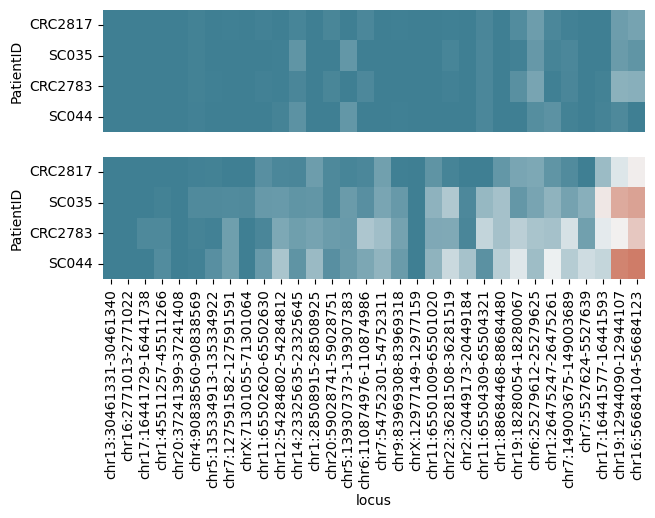

In [276]:
# Calculate tumor-normal by microsatellite length
fig, axes = plt.subplots(2, 1, figsize=(7, 3.5), dpi=100, sharex=True,)
# plt.figure(figsize=(7, 2), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['CRC2817', 'SC035', 'CRC2783', 'SC044']

vmin_e, vmax_e = -8, 0

ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==False)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[0],
            vmin=vmin_e, vmax=vmax_e,cbar=False
            )
ax.set_xlabel('');
ax.tick_params(bottom=False)
ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==True)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[1],
            vmin=vmin_e, vmax=vmax_e, cbar=False
            )


#### MSS

In [280]:
STRLocusAndCoverage_highCov = STRLocusAndCoverage[(STRLocusAndCoverage['Coverage']>=mininumCoverage) & 
                                                  ~(STRLocusAndCoverage['PatientID'].isin(['SC044', 'SC035', 'CRC2783', 'CRC2817'])) & 
                                                  (STRLocusAndCoverage['isTumor']!='N/A')].copy()

temp_set = set()
for locus, edf in STRLocusAndCoverage_highCov.groupby('locus'):
    if len(edf) >= 12:
        temp_set.add(locus)
STRLocusAndCoverage_highCov = STRLocusAndCoverage_highCov[STRLocusAndCoverage_highCov['locus'].isin(temp_set)].copy()
STRLocusAndCoverage_highCov['reference_STR_allele'] = [ int(locus.split(':')[1].split('-')[1])-int(locus.split(':')[1].split('-')[0])+1 for locus in STRLocusAndCoverage_highCov['locus'] ]
STRLocusAndCoverage_highCov.sort_values(['reference_STR_allele', 'locus'], inplace=True)

locus_order = list()
for locus in STRLocusAndCoverage_highCov['locus']:
    if locus in locus_order:
        pass 
    else:
        locus_order.append(locus)
STRLocusAndCoverage_highCov.shape[0]/12

8.0

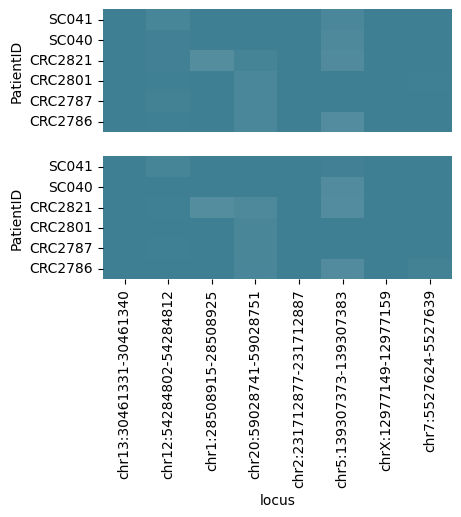

In [283]:
# Calculate tumor-normal by microsatellite length
fig, axes = plt.subplots(2, 1, figsize=(4.5, 3.5), dpi=100, sharex=True,)
# plt.figure(figsize=(7, 2), dpi=100)
palette_e = sns.diverging_palette(20, 220, as_cmap=True)
# palette_e = 'vlag_r'
# # list_reference_STR_allele = sufficientlyCoveredLoci2.pop('reference_STR_allele')
list_heatmap_patient_order = ['SC041', 'SC040', 'CRC2821', 'CRC2801', 'CRC2787', 'CRC2786', ]

vmin_e, vmax_e = -8, 0

ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==False)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[0],
            vmin=vmin_e, vmax=vmax_e,cbar=False
            )
ax.set_xlabel('');
ax.tick_params(bottom=False)
ax = sns.heatmap(STRLocusAndCoverage_highCov[(STRLocusAndCoverage_highCov['isTumor']==True)].pivot( index='PatientID', columns='locus', values='AvgSTRDiff' ).reindex(index=list_heatmap_patient_order, columns=locus_order), 
            cmap=palette_e, ax=axes[1],
            vmin=vmin_e, vmax=vmax_e, cbar=False
            )


#### KDE visualizations - Depr?

CRC2787	nan
CRC2801	nan


/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


CRC2786	nan
CRC2821	nan


/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


SC040	nan


/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


SC041	nan
CRC2817	nan


/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


CRC2783	nan


/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


SC035	nan
SC044	nan


/tmp/ipykernel_209179/1458228760.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):


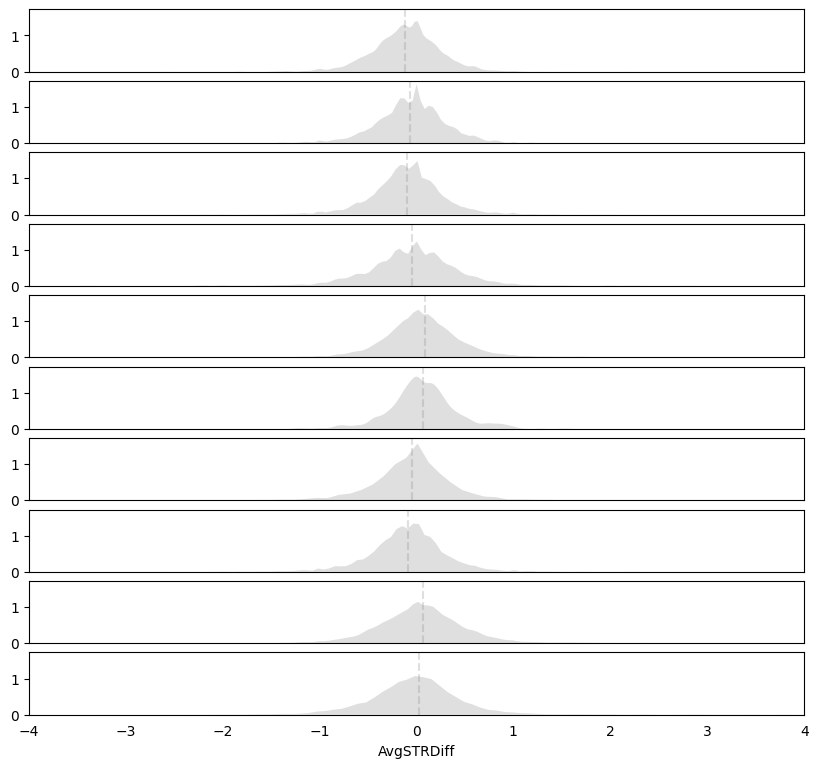

In [29]:
# All patients 
fig, axes = plt.subplots(10, 1, figsize=( 8, 7.5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 5
bw_adjust_e = 0.5

for idx, patient in enumerate(['CRC2787', 'CRC2801', 'CRC2786', 'CRC2821', 'SC040', 'SC041', 'CRC2817', 'CRC2783', 'SC035', 'SC044']):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial') & 
                        (adata.obs['Manual_CellType_lvl_1']!='Tumor epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1"):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

In [26]:
for PatientID, edf in adata.obs.groupby('PatientID'):
    print(PatientID, edf.iloc[0].MSI)

CRC2783 MSI-H
CRC2786 MSS
CRC2787 MSS
CRC2801 MSS
CRC2817 MSI-H
CRC2821 MSS
SC035 MSI-H
SC040 MSS
SC041 MSS
SC044 MSI-H


/tmp/ipykernel_209179/372022615.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata.obs.groupby('PatientID'):


##### 4 MSI patients

CRC2817	-0.55
SC035	-1.54
CRC2783	-1.63
SC044	-2.52


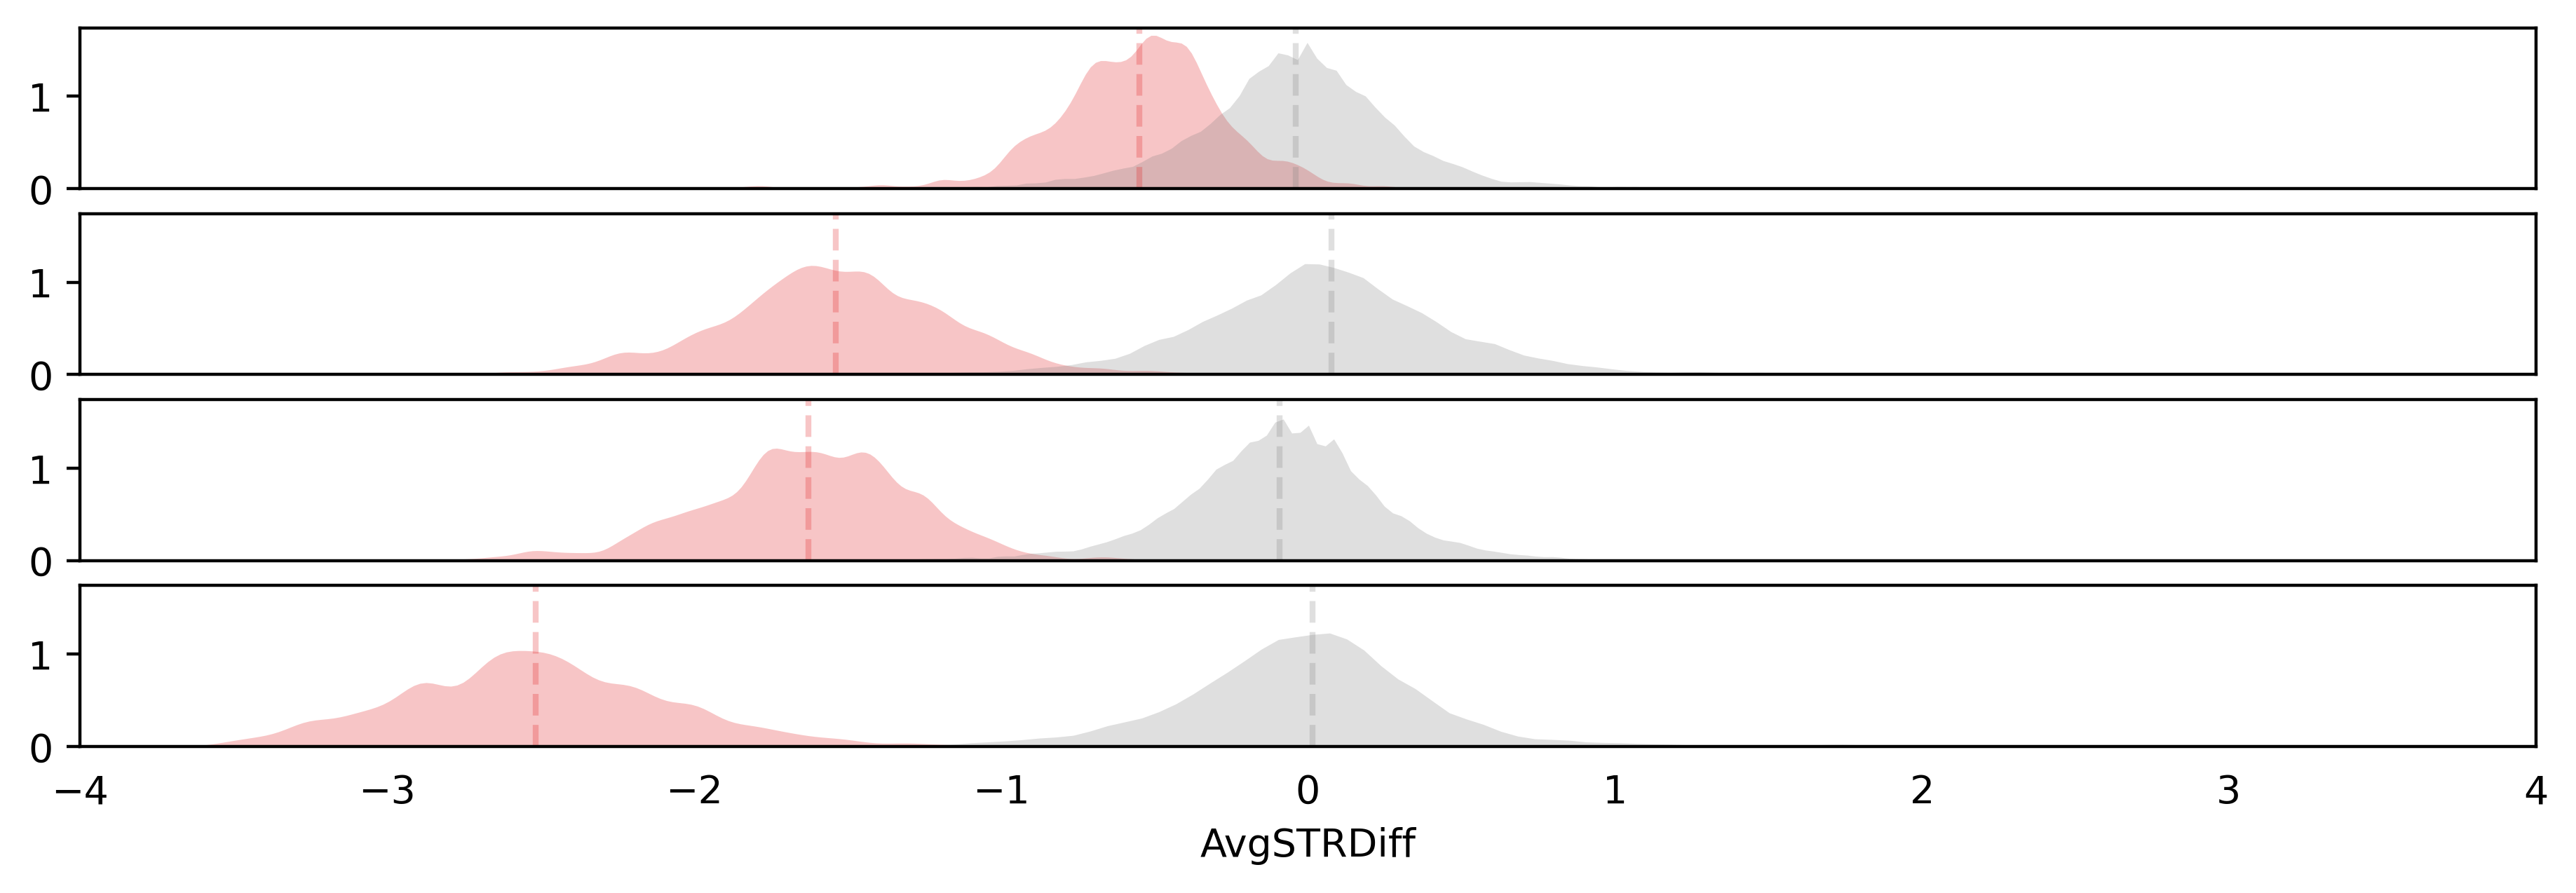

In [48]:
fig, axes = plt.subplots(4, 1, figsize=( 9, 3 ), dpi=400, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 10
bw_adjust_e = 0.5

for idx, patient in enumerate(['CRC2817', 'SC035', 'CRC2783', 'SC044']):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1", observed=False):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

##### 6 MSS patients

SC041	0.08
SC040	0.06
CRC2821	-0.04
CRC2801	-0.06
CRC2787	-0.07
CRC2786	-0.09


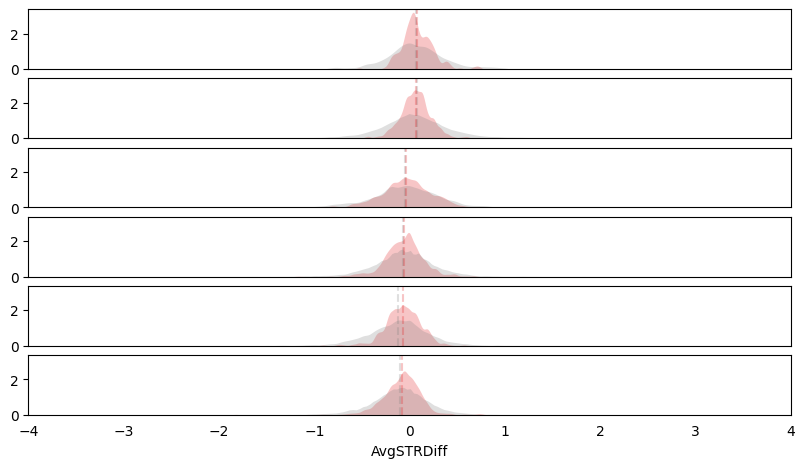

In [44]:
# All patients 
fig, axes = plt.subplots(6, 1, figsize=( 8, 4.5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 10
bw_adjust_e = 0.5

for idx, patient in enumerate(['SC041', 'SC040', 'CRC2821', 'CRC2801', 'CRC2787', 'CRC2786', ]):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1", observed=False):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

##### All patients

SC041	0.08
SC040	0.06
CRC2821	-0.04
CRC2801	-0.06
CRC2787	-0.07
CRC2786	-0.09
CRC2817	-0.55
SC035	-1.54
CRC2783	-1.63
SC044	-2.52


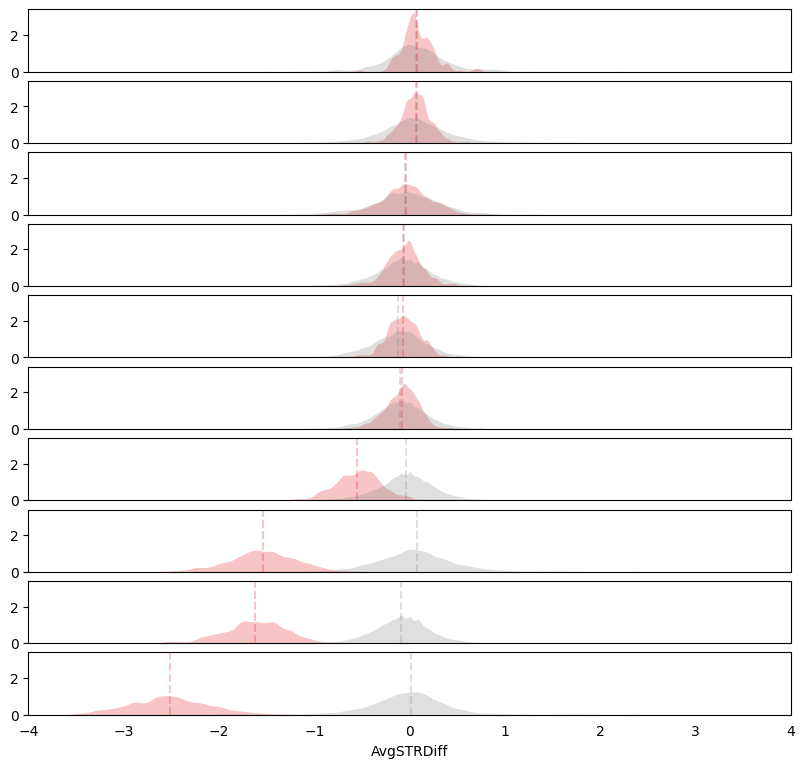

In [38]:
# All patients 
fig, axes = plt.subplots(10, 1, figsize=( 8, 7.5 ), dpi=100, sharex=True, sharey=True)
plot_type_oi = sns.kdeplot
palette_e = { 'Tumor epithelial' : sns.color_palette("Paired")[5], 'N/A' : 'gray', 'Normal epithelial' : 'gray', }

min_STRn = 10
bw_adjust_e = 0.5

for idx, patient in enumerate(['SC041', 'SC040', 'CRC2821', 'CRC2801', 'CRC2787', 'CRC2786', 'CRC2817', 'SC035', 'CRC2783', 'SC044']):

    adata_obs_oi = adata[(adata.obs['NumSTRLoci']>=min_STRn) & 
                        (adata.obs['PatientID']==patient) & 
                        (adata.obs['Manual_CellType_lvl_1']!='Normal epithelial')].obs
    print(f'{patient}\t{round(np.mean( adata_obs_oi[(adata_obs_oi['Manual_CellType_lvl_1']=="Tumor epithelial")]['AvgSTRDiff'] ), 2)}')

    plot_type_oi(data=adata_obs_oi, 
                        x='AvgSTRDiff', hue='Manual_CellType_lvl_1', 
                        legend=None, 
                        fill=True, linewidth=0, common_norm=False, bw_adjust=bw_adjust_e,
                        palette=palette_e, ax=axes[idx], 
                        )
    for Manual_CellType_lvl_1, edf in adata_obs_oi.groupby("Manual_CellType_lvl_1", observed=False):
        axes[idx].axvline( np.mean(edf['AvgSTRDiff']), color=palette_e[Manual_CellType_lvl_1], ls='--', alpha=0.25, )
    axes[idx].set_ylabel('');
    # axes[0].set_yticklabels([]);
    axes[idx].tick_params(left=True, bottom=False);

axes[idx].set_xlim([-4, 4]);
# axes[idx].set_ylim([0, 2.2]);

fig.tight_layout(pad=0.05,);

### Driver of MSI heterogeneity

In [409]:
adata_epi = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

adata_epi = adata_epi.raw.to_adata()
adata_epi = adata_epi[(adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])) & 
                      (adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial')]

sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.scale(adata_epi, max_value=10)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [408]:
STRProfileBulk = list()
for PatientID, edf in AlleleTable.groupby("PatientID"):
    for isTumor, edf2 in edf.groupby("isTumor"):
        STRProfileBulk.append( [PatientID, isTumor, np.mean(edf2['diff'].dropna()), len(edf2.dropna()), ] )
STRProfileBulk = pd.DataFrame(STRProfileBulk, columns=['PatientID', 'isTumor', 'AvgSTRDiff', 'NumSTRLoci'])
STRProfileBulk = STRProfileBulk[(STRProfileBulk['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])) & (STRProfileBulk['isTumor']==True)]
STRProfileBulk

,PatientID,isTumor,AvgSTRDiff,NumSTRLoci
1,CRC2783,True,-1.625290,68074
13,CRC2817,True,-0.545201,104578
19,SC035,True,-1.565406,113881
28,SC044,True,-2.543139,34829


In [420]:
X_CRC2817 = adata_epi[adata_epi.obs['PatientID']=='CRC2817'].X.copy()
X_CRC2783 = adata_epi[adata_epi.obs['PatientID']=='CRC2783'].X.copy()
X_SC035 = adata_epi[adata_epi.obs['PatientID']=='SC035'].X.copy()
X_SC044 = adata_epi[adata_epi.obs['PatientID']=='SC044'].X.copy()

list_sig_gene = list()
for idx, tup in enumerate(adata_epi.var.itertuples()):
    
    CRC2817_exp = np.mean( [arr.ravel()[idx] for arr in X_CRC2817] )
    CRC2783_exp = np.mean( [arr.ravel()[idx] for arr in X_CRC2783] )
    SC035_exp = np.mean( [arr.ravel()[idx] for arr in X_SC035] )
    SC044_exp = np.mean( [arr.ravel()[idx] for arr in X_SC044] )
    
    pearsonr = stats.pearsonr( x=[-0.545201, -1.565406, -1.625290, -2.543139], y=[CRC2817_exp, SC035_exp, CRC2783_exp, SC044_exp] )
    list_sig_gene.append( [tup.Index, CRC2817_exp, SC035_exp, CRC2783_exp, SC044_exp, pearsonr[0], pearsonr[1]] )

sig_gene = pd.DataFrame(list_sig_gene, columns=['gene', 'CRC2817_exp', 'SC035_exp', 'CRC2783_exp', 'SC044_exp', 'r', 'pval'])

/tmp/ipykernel_209179/429792619.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr = stats.pearsonr( x=[-0.545201, -1.565406, -1.625290, -2.543139], y=[CRC2817_exp, SC035_exp, CRC2783_exp, SC044_exp] )


In [612]:
sig_gene.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/MSI-gene_correlation.tsv', sep='\t', index=False)

In [618]:
sig_gene.sort_values('SC044_exp')

,gene,CRC2817_exp,SC035_exp,CRC2783_exp,SC044_exp,r,pval
19679,LGALS3,0.171351,0.381517,0.111727,-1.882815,0.772734,0.227266
20256,CRIP1,0.653297,-0.059544,-0.223677,-1.699180,0.965362,0.034638
25935,LGALS4,0.781227,-0.093806,-0.404354,-1.687248,0.984037,0.015963
1721,S100A6,0.979473,-0.449189,-0.344849,-1.544661,0.997082,0.002918
20085,IFI27,0.763045,-0.578263,0.177303,-1.501371,0.929817,0.070183
...,...,...,...,...,...,...,...
21901,NUPR1,-0.439615,-0.298621,0.024568,2.329015,-0.855413,0.144587
4193,DPP4,-0.330647,-0.260376,-0.260600,2.426314,-0.809257,0.190743
17072,CCND2,-0.363077,-0.238485,-0.238757,2.436733,-0.820121,0.179879
23764,PRAC1,-0.303400,-0.303400,-0.293169,2.514231,-0.795827,0.204173


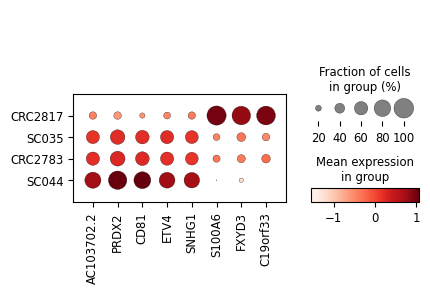

In [640]:
genelist_pos_cor = [ tup.gene for tup in sig_gene[sig_gene['pval']<=0.01].sort_values('r').itertuples() if max(list(tup)[2:6])>=0.7 ][:5]
genelist_neg_cor = [ tup.gene for tup in sig_gene[sig_gene['pval']<=0.01].sort_values('r', ascending=False).itertuples() if max(list(tup)[2:6])>=0.7 ][:3]

sc.pl.dotplot(adata_epi, var_names=genelist_pos_cor+genelist_neg_cor, groupby='PatientID', categories_order=['CRC2817', 'SC035', 'CRC2783', 'SC044', ],)

In [655]:
sc.tl.score_genes_cell_cycle(adata_chen, s_genes=cellcycle_marker[cellcycle_marker['phase']=='S']['gene_symbol'], g2m_genes=cellcycle_marker[cellcycle_marker['phase']=='G2/M']['gene_symbol'])

In [665]:
adata_chen.obs.columns

Index(['doublet_score', 'predicted_doublet', 'SampleID', 'PatientID',
       'BiopsySite', 'Accession', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'Identifier', 'Author_CellType_lvl_1', 'Author_CellType_lvl_2',
       'n_genes', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'MSI', 'Response',
       'Manual_CellType_lvl_1', 'score', 'goblet', 'Enterocytes', 'Stem',
       'S_score', 'G2M_score', 'phase'],
      dtype='object')

In [ ]:
# /node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv

In [662]:
sc.tl.score_genes(adata_chen, ['MUC2', 'CLCA1', 'FCBP'], score_name='goblet')
sc.tl.score_genes(adata_chen, ['SLC26A3', 'DMBT1'], score_name='Enterocytes')
sc.tl.score_genes(adata_chen, ['OLFM4', 'LGR5', 'ASCL2', 'SOX9'], score_name='Stem')

In [753]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
dict_PatientID_to_TumorLoc   = { list(tup)[1] : list(tup)[5] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorLoc['P15'] = 'Sigmoid colon'
dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_CancerType = { list(tup)[1] : list(tup)[4] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_chen.obs['TumorLocation'] = [ dict_PatientID_to_TumorLoc[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['CancerType'] = [ dict_PatientID_to_CancerType[PID] for PID in adata_chen.obs['PatientID'] ]
adata_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_chen.obs['PatientID'] ]

In [120]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
chen_patient_metadata

,Patient ID,Age,Gender,Cancer Type,Tumor Location,TNM,Tumor stage,dMMR/pMMR,MSI/MSS,POLE Mutation,TMB (Muts/Mb),Tumor Regression Ratio,Response,TRG status,Treatment Regimen
0,P01,51,Male,CRC,Descending colon,T4bN0M0,II,dMMR,MSS,Yes,Not avaliable,0.5648,CR,TRG0,Pembrolizumab
1,P02,56,Male,CRC,Ascending colon,T4bN2M1,IV,pMMR,MSS,No,3.58,-0.0196,SD,TRG3,Pembrolizumab
2,P03,66,Male,CRC,Low rectum,T3bN2aM0,III,pMMR,MSS,No,Not avaliable,0.4541,PR,TRG2,Pembrolizumab + CapeOx
3,P04,47,Female,CRC,Ascending colon,T4aN+M0,III,dMMR,MSI,No,487,0.9180,CR,TRG0,Pembrolizumab
4,P05,63,Female,CRC,Low rectum,T3N+M0,III,pMMR,MSS,No,3.05,0.3333,PR,TRG2,Sintilimab+ CapeOx
5,P08,52,Male,CRC,Low rectum,T3N1M0,III,dMMR,MSI,No,121.64,0.8813,CR,TRG0,Pembrolizumab
6,P09,64,Male,CRC,Low rectum,T3bN2b,III,pMMR,MSS,No,4.75,0.9156,CR,TRG0,Sintilimab+ CapeOx
7,P11,65,Male,Duodenal carcinoma,Duodenum,T3N0M0,II,dMMR,MSI,No,1.78,1.0000,CR,TRG0,Pembrolizumab
8,P12,60,Male,CRC,Descending colon,T4bN2bM0,III,dMMR,MSI,No,114.72,0.0090,CR,TRG0,Pembrolizumab
9,P14,58,Male,CRC,Low rectum,T3N2bM0,III,pMMR,MSS,No,Not avaliable,0.2272,PR,TRG2,Sintilimab + CapeOx


In [785]:
sc.tl.score_genes(adata_chen, gene_list=['DNMT3A'])

In [786]:
MSI_degree = list()
for PatientID, edf in adata_chen.obs.groupby("PatientID"):
    MSI_degree.append( [PatientID, np.mean(edf['AvgSTRDiff'].dropna()), 
                        np.mean(edf['Stem']), np.mean(edf['score']), np.mean(edf['S_score']), len(edf),
                        edf.iloc[0].Age, edf.iloc[0].CancerType, edf.iloc[0].TumorLocation, edf.iloc[0].TumorStage, edf.iloc[0].TumorRegressionRatio, edf.iloc[0].Response
                        ] )
MSI_degree = pd.DataFrame(MSI_degree, columns=['PatientID', 'AvgSTRDiff', 'StemScore', 'GeneScore', 'Sscore', 'CellCount', 
                                               'Age', 'CancerType', 'TumorLocation', 'TumorStage', 'TumorRegressionRatio', 'Response'])
MSI_degree.sort_values('AvgSTRDiff', inplace=True)

/tmp/ipykernel_209179/443431625.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_chen.obs.groupby("PatientID"):


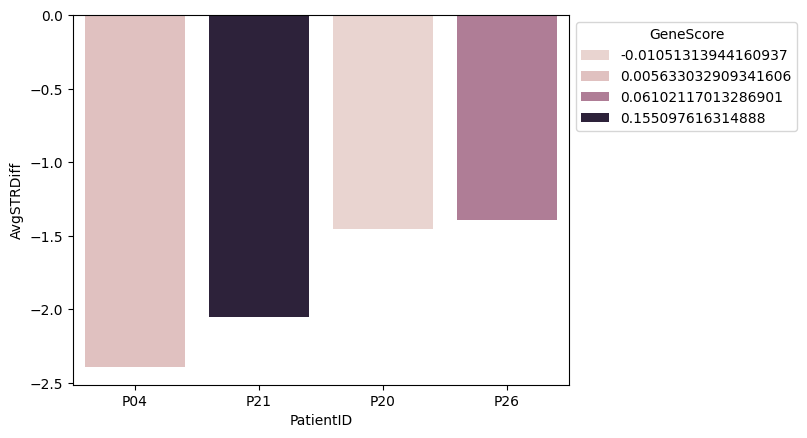

In [790]:
ax = sns.barplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & 
                                 (MSI_degree['TumorLocation']=='Ascending colon')], x='PatientID', y='AvgSTRDiff', 
                 hue='GeneScore', 
                 # palette=sns.diverging_palette(220, 20, as_cmap=True),
                 )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

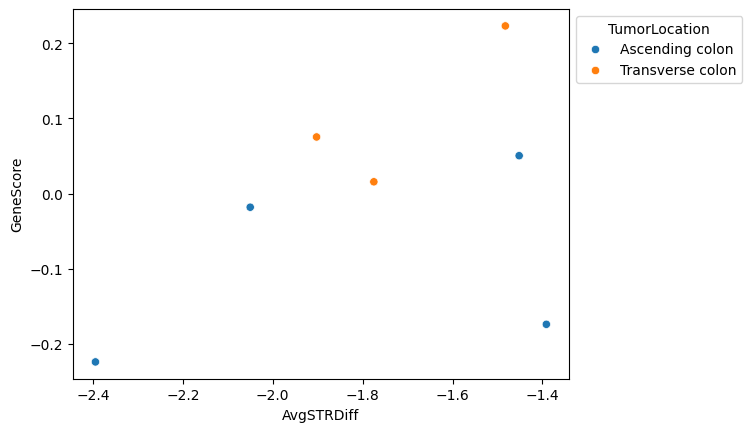

In [784]:
ax = sns.scatterplot(data=MSI_degree[(MSI_degree['CancerType']=='CRC') & 
                                 (MSI_degree['TumorLocation']!='Sigmoid colon')], x='AvgSTRDiff', y='GeneScore', hue='TumorLocation')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

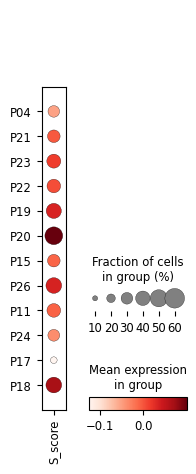

In [667]:
sc.pl.dotplot(adata_chen, var_names=['S_score', 'G2M_score'], groupby='PatientID', 
              categories_order=['P04', 'P21', 'P23', 'P22', 'P19', 'P20', 'P15', 'P26', 'P11', 'P24', 'P17', 'P18'],
              )

In [470]:
adata_chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')
adata_chen = adata_chen[adata_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial']

adata_chen = adata_chen.raw.to_adata()
adata_chen = adata_chen[(adata_chen.obs['MSI']=='MSI') & ~(adata_chen.obs['PatientID'].isin(['P08', 'P12']))] 

sc.pp.normalize_total(adata_chen)
sc.pp.log1p(adata_chen)
sc.pp.scale(adata_chen, max_value=10)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [557]:
dict_PatientID_to_AvgSTRDiff = dict()
for PatientID, edf in adata_chen.obs[(adata_chen.obs['NumSTRLoci']!=0)].groupby('PatientID'):
    dict_PatientID_to_AvgSTRDiff[PatientID] = np.mean(edf['AvgSTRDiff'])
dict_PatientID_to_AvgSTRDiff = dict(sorted(dict_PatientID_to_AvgSTRDiff.items(), key=lambda x:x[1]))
dict_PatientID_to_AvgSTRDiff

/tmp/ipykernel_209179/2765650158.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_chen.obs[(adata_chen.obs['NumSTRLoci']!=0)].groupby('PatientID'):


{'P04': -2.400360625105161,
 'P21': -2.0550661582522483,
 'P23': -1.9036044752133918,
 'P22': -1.819170687677332,
 'P19': -1.4978381501021447,
 'P20': -1.4562576993355703,
 'P15': -1.4167480147951217,
 'P26': -1.3940898449843884,
 'P11': -1.3013453458299546,
 'P24': -1.1220420625798324,
 'P17': -1.0553414293321977,
 'P18': -0.6639958362623589}

In [558]:
X_P04 = adata_chen[adata_chen.obs['PatientID']=='P04'].X.copy()
X_P21 = adata_chen[adata_chen.obs['PatientID']=='P21'].X.copy()
X_P23 = adata_chen[adata_chen.obs['PatientID']=='P23'].X.copy()
X_P22 = adata_chen[adata_chen.obs['PatientID']=='P22'].X.copy()
X_P19 = adata_chen[adata_chen.obs['PatientID']=='P19'].X.copy()
X_P20 = adata_chen[adata_chen.obs['PatientID']=='P20'].X.copy()
X_P15 = adata_chen[adata_chen.obs['PatientID']=='P15'].X.copy()
X_P26 = adata_chen[adata_chen.obs['PatientID']=='P26'].X.copy()
X_P11 = adata_chen[adata_chen.obs['PatientID']=='P11'].X.copy()
X_P24 = adata_chen[adata_chen.obs['PatientID']=='P24'].X.copy()
X_P17 = adata_chen[adata_chen.obs['PatientID']=='P17'].X.copy()
X_P18 = adata_chen[adata_chen.obs['PatientID']=='P18'].X.copy()

list_sig_gene = list()
for idx, tup in enumerate(adata_chen.var.itertuples()):
    
    P04_exp = np.mean( [arr.ravel()[idx] for arr in X_P04] )
    P21_exp = np.mean( [arr.ravel()[idx] for arr in X_P21] )
    P23_exp = np.mean( [arr.ravel()[idx] for arr in X_P23] )
    P22_exp = np.mean( [arr.ravel()[idx] for arr in X_P22] )
    P19_exp = np.mean( [arr.ravel()[idx] for arr in X_P19] )
    P20_exp = np.mean( [arr.ravel()[idx] for arr in X_P20] )
    P15_exp = np.mean( [arr.ravel()[idx] for arr in X_P15] )
    P26_exp = np.mean( [arr.ravel()[idx] for arr in X_P26] )
    P11_exp = np.mean( [arr.ravel()[idx] for arr in X_P11] )
    P24_exp = np.mean( [arr.ravel()[idx] for arr in X_P24] )
    P17_exp = np.mean( [arr.ravel()[idx] for arr in X_P17] )
    P18_exp = np.mean( [arr.ravel()[idx] for arr in X_P18] )

    
    pearsonr = stats.pearsonr( x=[-0.6639958362623589, -1.0548491991879196, -1.0959204484245346, -1.2873308574902476,
                                  -1.3912988743237589, -1.4012078171922502, -1.4518178892766203, -1.4825265153747023, 
                                  -1.7750695800972756, -1.902498371509026, -2.0501022303337644, -2.3943994646123503], 
                              y=[P18_exp, P17_exp, P24_exp, P11_exp, P26_exp, P15_exp, P20_exp, P19_exp, P22_exp, P23_exp, P21_exp, P04_exp, ] )
    list_sig_gene.append( [tup.Index, P18_exp, P17_exp, P24_exp, P11_exp, P26_exp, P15_exp, P20_exp, P19_exp, P22_exp, P23_exp, P21_exp, P04_exp, pearsonr[0], pearsonr[1]] )
    
sig_gene_chen = pd.DataFrame(list_sig_gene, columns=['gene', 
                                                     'P04_exp', 'P21_exp', 'P23_exp', 'P22_exp', 'P19_exp', 'P20_exp', 'P15_exp', 'P26_exp', 'P11_exp', 'P24_exp', 'P17_exp', 'P18_exp', 
                                                     'r', 'pval'])

/tmp/ipykernel_209179/3495753154.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr = stats.pearsonr( x=[-0.6639958362623589, -1.0548491991879196, -1.0959204484245346, -1.2873308574902476,


In [ ]:
sig_gene_chen.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/MSI-gene_correlation.tsv', sep='\t', index=False)

In [581]:
sig_gene_chen[sig_gene_chen['pval']<=0.05].sort_values('r')[['gene', 'r', 'pval']]

,gene,r,pval
29071,CDK16,-0.941950,0.000005
29035,DDX3X,-0.920652,0.000022
26732,ZNF808,-0.899089,0.000069
28851,AKAP17A,-0.892307,0.000095
21209,CD276,-0.887529,0.000117
...,...,...,...
27533,B4GALT5,0.817044,0.001177
6955,DCUN1D4,0.830270,0.000828
22067,USP31,0.835598,0.000713
16492,CLCF1,0.855323,0.000390


In [602]:
for gene in sig_gene_chen[sig_gene_chen['pval']<=0.05].sort_values('r').head(50)['gene']:
    joanito_r = sig_gene[sig_gene['gene']==gene].iloc[0]['r']
    joanito_p = sig_gene[sig_gene['gene']==gene].iloc[0]['pval']
    if joanito_p <= 0.2:
        print(gene, round(joanito_r, 2))

ZNF808 -0.99
RUVBL1-AS1 -0.86
MBD1 -0.99
ZNF577 -0.85
CATSPERB 0.81
AL049830.3 -0.87
FN3K -0.85
COL14A1 -0.99
AEBP2 0.85
RGMB -0.98
MAP1LC3A -0.92
USP22 -0.89
BBOX1-AS1 -0.94
FGF5 0.84
ZFC3H1 0.99


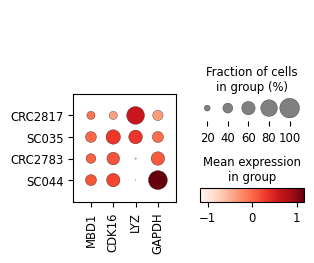

In [610]:
sc.pl.dotplot(adata_epi, var_names=['MBD1', 'CDK16', 'LYZ', 'GAPDH'], groupby='PatientID', categories_order=['CRC2817', 'SC035', 'CRC2783', 'SC044', ],)

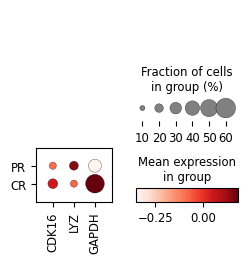

In [608]:
sc.pl.dotplot(adata_chen, var_names=['CDK16', 'LYZ', 'GAPDH'], groupby='Response', 
              categories_order=['PR', 'CR'],)

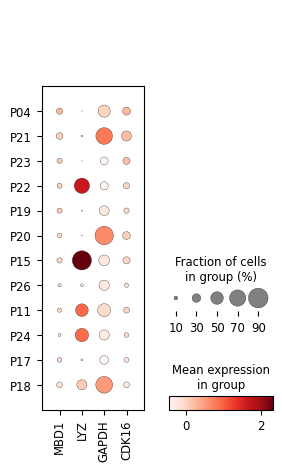

In [611]:
sc.pl.dotplot(adata_chen, var_names=['MBD1', 'LYZ', 'GAPDH', 'CDK16'], groupby='PatientID', 
              categories_order=['P04', 'P21', 'P23', 'P22', 'P19', 'P20', 'P15', 'P26', 'P11', 'P24', 'P17', 'P18'],)

/tmp/ipykernel_209179/1111436741.py:3: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
  adata_epi.layers["scaled"] = sc.pp.scale(adata_epi, copy=True).X
/tmp/ipykernel_209179/1111436741.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_epi.obs.groupby("SampleID"):


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


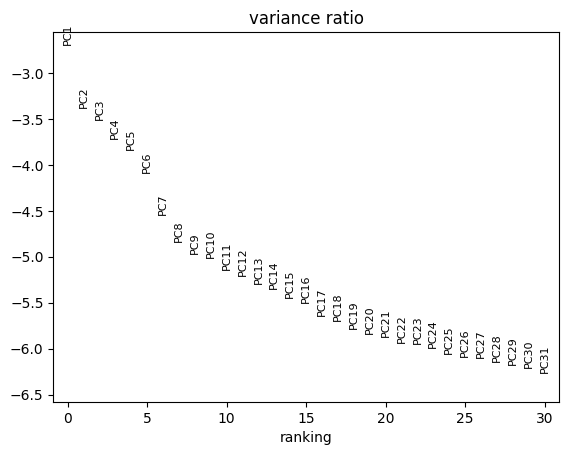

In [341]:
adata_epi = adata_epi.raw.to_adata()
adata_epi = adata_epi[(adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])) & 
                      (adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial')]
adata_epi.layers["scaled"] = sc.pp.scale(adata_epi, copy=True).X

onlySingleCellSample = list()
for SampleID, edf in adata_epi.obs.groupby("SampleID"):
    if len(edf) <= 1:
        print(SampleID)
        onlySingleCellSample.append(SampleID)
adata_epi = adata_epi[~(adata_epi.obs['SampleID'].isin(onlySingleCellSample))].copy()

sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.highly_variable_genes(adata_epi, n_top_genes=2000, batch_key="SampleID")
sc.pp.scale(adata_epi, max_value=10)

adata_epi.raw = adata_epi.copy()
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [342]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi,)

In [343]:
for PatientID, edf in adata_epi[adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])].obs.groupby('PatientID'):
    print(PatientID,)

CRC2783
CRC2817
SC035
SC044


/tmp/ipykernel_209179/3236238909.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi[adata_epi.obs['PatientID'].isin(['SC035', 'SC044', 'CRC2817', 'CRC2783'])].obs.groupby('PatientID'):


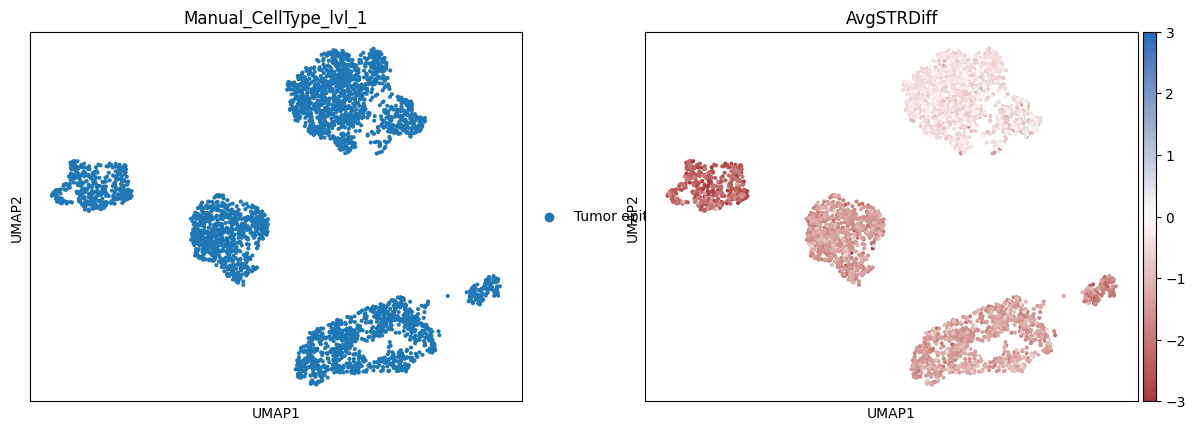

In [345]:
sc.pl.umap(adata_epi, color=['Manual_CellType_lvl_1', 'AvgSTRDiff'], cmap='vlag_r', vmin=-3, vmax=3)

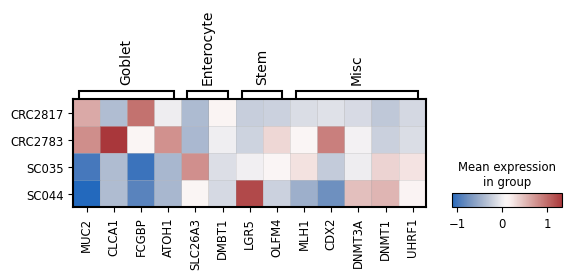

In [381]:
sc.pl.matrixplot(adata_epi, var_names={ 'Goblet' : ['MUC2', 'CLCA1', 'FCGBP', 'ATOH1'], 
                                    'Enterocyte' : ['SLC26A3', 'DMBT1', ], 
                                    'Stem' : ['LGR5', 'OLFM4', ], 
                                    'Misc' : ['MLH1', 'CDX2', 'DNMT3A', 'DNMT1', 'UHRF1', ] }, 
              groupby='PatientID', cmap='vlag',
              categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              )

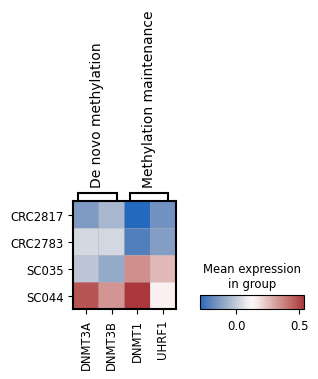

In [394]:
sc.pl.matrixplot(adata_epi, var_names={ 'De novo methylation' : ['DNMT3A', 'DNMT3B', ], 'Methylation maintenance' : ['DNMT1', 'UHRF1',], }, 
              groupby='PatientID', cmap='vlag',
              categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              )

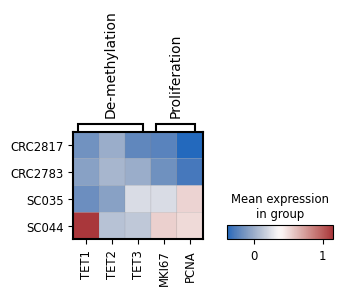

In [399]:
sc.pl.matrixplot(adata_epi, var_names={ 'De-methylation' : ['TET1', 'TET2', 'TET3', ], 'Proliferation' : ['MKI67', 'PCNA'] }, 
              groupby='PatientID', cmap='vlag',
              categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
              )